In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=e8485bf4bfdabddd8e2c5c94b4efcabbe76aa5a9c5852f083eb840ceea6b2790
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


# Importing Required Libraries

In [4]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline
import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle #shuffling the data improves the model

# Mounting Google drive and accessing the dataset directory

In [5]:
from google.colab import drive
import os

# Mounting Google Drive
drive.mount('/content/drive')

# Navigating to the dataset directory
image_dir="/content/drive/MyDrive/brain_tumor_dataset"


# Verifying the brain tumour dataset directory exists
if os.path.exists(image_dir):
    print("dataset directory exists!")
    # List the contents of the CNN directory
    print("Contents of dataset directory:", os.listdir(image_dir))
else:
    print("dataset directory does not exist")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset directory exists!
Contents of dataset directory: ['yes', 'no']


About the data:

The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous andno contains 98 Brain MRI Images that are non-tumorous.

In [6]:
# Path to the dataset directory in google colab
image_dir

'/content/drive/MyDrive/brain_tumor_dataset'

In [7]:
# labels
dataset_path = os.listdir(image_dir)
labels = os.listdir(image_dir)
labels

['yes', 'no']

# Accessing and Storing all images

In [8]:
all_images = []

for item in labels:
 images = os.listdir(image_dir + '/' +item)
 for image in images:
    all_images.append((item, str(image_dir + '/' +item) + '/' + image))

In [9]:
# No. of images
len(all_images)

253

In [10]:
# The folder 'yes' contains 155 Brain MRI Images that are tumorous and folder 'no' contains 98 Brain MRI Images that are non-tumorous.
for items in dataset_path:
  print(items,':',len(os.listdir(image_dir +'/'+items)))

yes : 155
no : 98


In [11]:
# Displaying first five records from all_images
all_images[:5]

[('yes', '/content/drive/MyDrive/brain_tumor_dataset/yes/Y58.JPG'),
 ('yes', '/content/drive/MyDrive/brain_tumor_dataset/yes/Y106.jpg'),
 ('yes', '/content/drive/MyDrive/brain_tumor_dataset/yes/Y251.JPG'),
 ('yes', '/content/drive/MyDrive/brain_tumor_dataset/yes/Y17.jpg'),
 ('yes', '/content/drive/MyDrive/brain_tumor_dataset/yes/Y259.JPG')]

In [12]:
#for filename in all_images:
#  print(filename[1])


In [13]:
# Building a dataframe
df = pd.DataFrame(data=all_images, columns=['labels', 'images'])
print(df.head())

  labels                                             images
0    yes  /content/drive/MyDrive/brain_tumor_dataset/yes...
1    yes  /content/drive/MyDrive/brain_tumor_dataset/yes...
2    yes  /content/drive/MyDrive/brain_tumor_dataset/yes...
3    yes  /content/drive/MyDrive/brain_tumor_dataset/yes...
4    yes  /content/drive/MyDrive/brain_tumor_dataset/yes...


In [14]:
df['labels'].value_counts()

labels
yes    155
no      98
Name: count, dtype: int64

In [15]:
labels

['yes', 'no']

# Reading and resizing images(224* 224* 3) using OpenCV

In [17]:
path = image_dir + "/"


im_size = 224                # Because VGG16 uses 224*224*3 structure

images = []
label_imgs = []

for i in labels:
    data_path = path + str(i)  # Adding path to 1st folder and then 2nd folder and then 3rd folder
    #filenames = [i for i in os.listdir(data_path) if i.endswith('.jpg')]
    filenames = [i for i in os.listdir(data_path) ] # Traversing through each image of that folder and storing
   # print(filenames)  # will get the names of all images which ends with .jpg extension
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)  # reading that image as array
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        label_imgs.append(i)

In [53]:
# Image array for firs image
images[:1]

[array([[[21, 21, 21],
         [21, 21, 21],
         [21, 21, 21],
         ...,
         [18, 18, 18],
         [18, 18, 18],
         [19, 19, 19]],
 
        [[21, 21, 21],
         [21, 21, 21],
         [21, 21, 21],
         ...,
         [18, 18, 18],
         [18, 18, 18],
         [19, 19, 19]],
 
        [[21, 21, 21],
         [21, 21, 21],
         [21, 21, 21],
         ...,
         [18, 18, 18],
         [18, 18, 18],
         [19, 19, 19]],
 
        ...,
 
        [[24, 24, 24],
         [24, 24, 24],
         [24, 24, 24],
         ...,
         [21, 21, 21],
         [21, 21, 21],
         [21, 21, 21]],
 
        [[24, 24, 24],
         [24, 24, 24],
         [24, 24, 24],
         ...,
         [21, 21, 21],
         [21, 21, 21],
         [21, 21, 21]],
 
        [[24, 24, 24],
         [24, 24, 24],
         [24, 24, 24],
         ...,
         [21, 21, 21],
         [21, 21, 21],
         [21, 21, 21]]], dtype=uint8)]

In [18]:
imagescv = images
imagescv = np.array(imagescv)

In [19]:
# Transforming the image array to a numpy array

images = np.array(images)

images.shape

(253, 224, 224, 3)

In [20]:
# Normalizing each image pixel values in the range [0,1]
images = images.astype('float32') / 255.0

In [21]:
df.sample(5)

,labels,images
50,yes,/content/drive/MyDrive/brain_tumor_dataset/yes...
159,no,/content/drive/MyDrive/brain_tumor_dataset/no/...
166,no,/content/drive/MyDrive/brain_tumor_dataset/no/...
3,yes,/content/drive/MyDrive/brain_tumor_dataset/yes...
228,no,/content/drive/MyDrive/brain_tumor_dataset/no/...


In [22]:
y=df['labels'].values
print(y[:5])

['yes' 'yes' 'yes' 'yes' 'yes']


In [23]:
# Label Encoding
y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y[:5])

[1 1 1 1 1]


1 means 'yes' and 0 means 'no'

In [24]:
# Defining paths
image_dir = "/content/drive/MyDrive/brain_tumor_dataset"
augment_dir = "/content/drive/MyDrive/brain_tumor_dataset_augmented"
crop_dir = "/content/drive/MyDrive/brain_tumor_dataset_cropped"

# Defining the image size
image_size = (224, 224)

In [25]:
# Creating directories for augmented and cropped images if they don't exist
os.makedirs(augment_dir, exist_ok=True)
os.makedirs(crop_dir, exist_ok=True)

### Function to crop brain contours from images

In [26]:
def crop_brain_contour(image, plot=False):
    # Ensuring the image is in grayscale
    if len(image.shape) != 2:  # Checking if it's already grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blurring the image slightly to reduce noise
    gray = cv2.GaussianBlur(image, (5, 5), 0)

    # Applying binary thresholding
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)

    # Performing morphological operations to clean up the image
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Finding contours in the thresholded image
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not cnts:
        print("No contours found.")
        return image  # Returning original image if no contours are found

    # This line help us get the largest contour
    c = max(cnts, key=cv2.contourArea)

    # Trying to get extreme points of the image
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Cropping the image using the extreme points(for better training)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image, cmap='gray')
        plt.title('Cropped Image')
        plt.axis('off')

        plt.show()

    return new_image


### Function to augment and save images in the brain_tumour_augmented directory

In [27]:
def augment_and_save_images(image_dir, save_dir, crop_dir):
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=True
    )

    for label in labels:
        label_dir = os.path.join(image_dir, label)
        save_label_dir = os.path.join(save_dir, label)
        crop_label_dir = os.path.join(crop_dir, label)

        os.makedirs(save_label_dir, exist_ok=True)
        os.makedirs(crop_label_dir, exist_ok=True)

        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if image is None:
                continue

            image = cv2.resize(image, (224, 224))
            image_exp = np.expand_dims(image, axis=-1)
            image_exp = np.repeat(image_exp, 3, axis=-1)  # Expand grayscale to 3-channel

            # Augmenting the image
            augmented_iter = data_gen.flow(np.expand_dims(image_exp, 0), batch_size=1)

            for _ in range(1):  # Generating 1 augmented version per original
                augmented_image = next(augmented_iter)[0].astype(np.uint8)
                aug_img_path = os.path.join(save_label_dir, 'aug_' + filename)
                cv2.imwrite(aug_img_path, cv2.cvtColor(augmented_image, cv2.COLOR_BGR2GRAY))

                # Cropping the augmented image
                cropped_image = crop_brain_contour(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2GRAY))
                crop_img_path = os.path.join(crop_label_dir, 'crop_' + filename)
                cv2.imwrite(crop_img_path, cropped_image)

augment_and_save_images(image_dir, augment_dir, crop_dir)

In [28]:
# Loading augmented and cropped images into numpy arrays
def load_images(image_dir, labels, image_size=(224, 224)):
    images = []
    y = []

    for label in labels:
        label_dir = os.path.join(image_dir, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                continue
            image = cv2.resize(image, image_size)
            images.append(image)
            y.append(1 if label == 'yes' else 0)

    images = np.array(images)
    images = np.expand_dims(images, axis=-1)
    images = np.repeat(images, 3, axis=-1)  # Converting grayscale to 3-channel
    y = np.array(y)
    return images, y

In [29]:
original_images, original_labels = load_images(image_dir, labels)
augmented_images, augmented_labels = load_images(augment_dir, labels)
cropped_images, cropped_labels = load_images(crop_dir, labels)

In [30]:
# Combining all images and labels from all three directories (origional , augmented and cropped directory)
all_images = np.concatenate([original_images, augmented_images, cropped_images], axis=0)
all_labels = np.concatenate([original_labels, augmented_labels, cropped_labels], axis=0)

In [31]:
# Train test split
all_images, all_labels = shuffle(all_images, all_labels, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(all_images, all_labels, test_size=0.1, random_state=415)

In [32]:
print("Training data shape:", train_x.shape, train_y.shape)
print("Testing data shape:", test_x.shape, test_y.shape)

Training data shape: (683, 224, 224, 3) (683,)
Testing data shape: (76, 224, 224, 3) (76,)


In [33]:
# Visualizing the original, augmented, and cropped images
def visualize_images(original, augmented, cropped):
    plt.figure(figsize=(7, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(augmented, cmap='gray')
    plt.title('Augmented Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cropped, cmap='gray')
    plt.title('Cropped Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


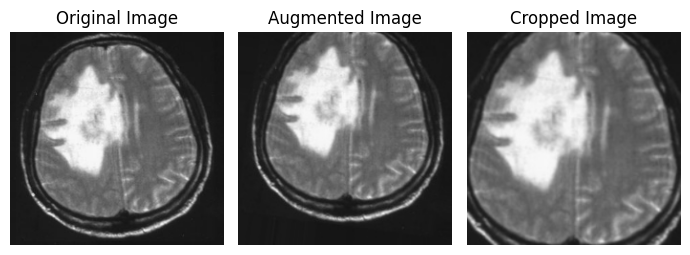

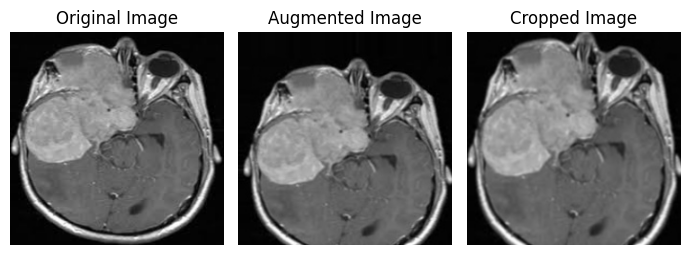

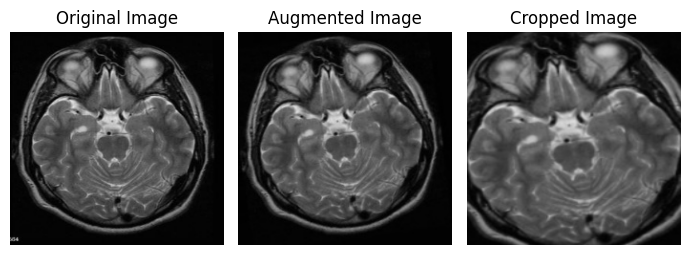

In [34]:
# Displaying 3 images to show the image transformation after augmentation and cropping
for i in range(3):
    visualize_images(
        original_images[i],
        augmented_images[i],
        cropped_images[i]
    )

## Building and training VGG16 model

In [35]:
def build_vgg16_model(input_shape=(224, 224, 3), num_classes=1):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze layers (top layers)
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  # Using the 'sigmoid' activation function for binary classification
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),   # Using Adam Optimizer
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [36]:
# Initializing and training the model
vgg16_model = build_vgg16_model()
vgg16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14846273 (56.63 MB)
Trainable params: 13158

In [37]:
# Training the model
history = vgg16_model.fit(
    train_x, train_y,
    validation_split=0.1,
    epochs=30,
    batch_size=16,
    shuffle=True
)

Epoch 1/30
39/39 [==============================] - 14s 331ms/step - loss: 3.1404 - accuracy: 0.5244 - val_loss: 0.7989 - val_accuracy: 0.7101
Epoch 2/30
39/39 [==============================] - 12s 320ms/step - loss: 1.5888 - accuracy: 0.6059 - val_loss: 0.6283 - val_accuracy: 0.7246
Epoch 3/30
39/39 [==============================] - 12s 321ms/step - loss: 1.3148 - accuracy: 0.6971 - val_loss: 0.6656 - val_accuracy: 0.7536
Epoch 4/30
39/39 [==============================] - 12s 321ms/step - loss: 1.1925 - accuracy: 0.7052 - val_loss: 0.5715 - val_accuracy: 0.7826
Epoch 5/30
39/39 [==============================] - 13s 324ms/step - loss: 0.8443 - accuracy: 0.7606 - val_loss: 0.5207 - val_accuracy: 0.8116
Epoch 6/30
39/39 [==============================] - 13s 324ms/step - loss: 0.8122 - accuracy: 0.7687 - val_loss: 0.4810 - val_accuracy: 0.8116
Epoch 7/30
39/39 [==============================] - 13s 324ms/step - loss: 0.7276 - accuracy: 0.7818 - val_loss: 0.5092 - val_accuracy: 0.8406

# Plotting graph to check Overfitting

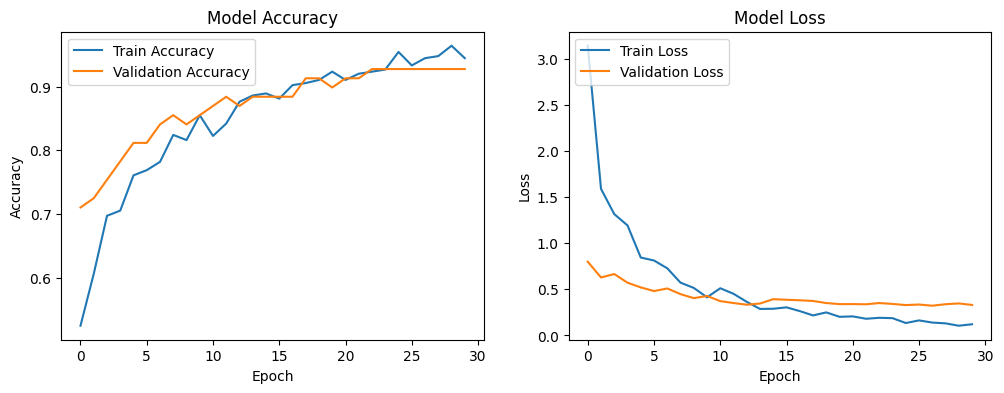

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plotting training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

* Around epochs 23-25, both training and validation accuracies are high, and validation loss is reasonably low and stable.
* Training and Validation accuracies improve and stabilize at a high level, suggesting the model generalizes well to unseen data.
* Validation loss does not increase significantly while the training loss decreases, indicating that overfitting is minimal or well-managed.
* Some fluctuations in validation loss are normal, especially in smaller datasets, and may not indicate overfitting if the validation accuracy remains stable or improves.

## Retraining the VGG16 Model with optimal epochs(24)

In [39]:
# Initializing and training the model
vgg16_model_updated = build_vgg16_model()
vgg16_model_updated.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14846273 (56.63 MB)
Trainable params: 131585 (514.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_______

In [40]:
history_updated = vgg16_model_updated.fit(
    train_x, train_y,
    epochs=24,
    batch_size=1,
    shuffle=True
)

Epoch 1/24
683/683 [==============================] - 36s 51ms/step - loss: 1.1641 - accuracy: 0.6823
Epoch 2/24
683/683 [==============================] - 35s 51ms/step - loss: 0.6050 - accuracy: 0.8082
Epoch 3/24
683/683 [==============================] - 35s 51ms/step - loss: 0.4060 - accuracy: 0.8580
Epoch 4/24
683/683 [==============================] - 35s 51ms/step - loss: 0.2683 - accuracy: 0.8770
Epoch 5/24
683/683 [==============================] - 35s 51ms/step - loss: 0.2388 - accuracy: 0.8946
Epoch 6/24
683/683 [==============================] - 35s 51ms/step - loss: 0.1703 - accuracy: 0.9341
Epoch 7/24
683/683 [==============================] - 35s 51ms/step - loss: 0.1349 - accuracy: 0.9414
Epoch 8/24
683/683 [==============================] - 35s 51ms/step - loss: 0.1344 - accuracy: 0.9531
Epoch 9/24
683/683 [==============================] - 35s 51ms/step - loss: 0.1065 - accuracy: 0.9546
Epoch 10/24
683/683 [==============================] - 35s 51ms/step - loss: 0.104

## We got a validation accuracy of **98.68%** without any overfitting.

# Checking the prediction of VGG16 Model on New Images

1/1 [==============================] - 0s 71ms/step


<ipython-input-42-7b50bf695357>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_index = int(prediction[0] > 0.5)  # Binary classification threshold at 0.5


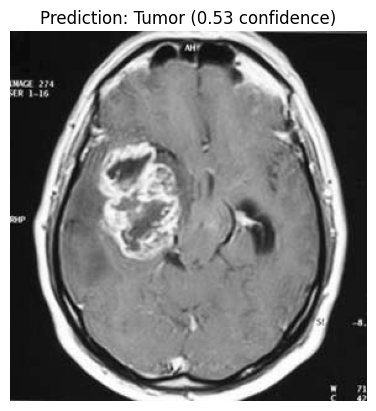

Predicted Class: Tumor, Confidence: 0.53


In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to preprocess a new image
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")

    # Resize the image
    image = cv2.resize(image, target_size)

    # Expanding the dimensions to match the model's input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.repeat(image, 3, axis=-1)    # Repeat channels to simulate RGB

    # Normalizing the image
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    return image

# Function to predict the class of a new image
def predict_image(model, image_path, class_labels=['No Tumor', 'Tumor']):
    # Preprocessing the image
    preprocessed_image = preprocess_image(image_path)

    # Making prediction
    prediction = model.predict(preprocessed_image)

    # Interpreting prediction
    class_index = int(prediction[0] > 0.5)  # Binary classification threshold at 0.5
    class_label = class_labels[class_index]
    confidence = prediction[0][0] if class_index == 1 else 1 - prediction[0][0]

    # Displaying the image and prediction
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title(f"Prediction: {class_label} ({confidence:.2f} confidence)")
    plt.axis('off')
    plt.show()

    return class_label, confidence

# Path to new image
new_image_path = '/content/drive/MyDrive/new_images/Y17.jpg'  # Path to a new image
class_label, confidence = predict_image(vgg16_model, new_image_path)
print(f"Predicted Class: {class_label}, Confidence: {confidence:.2f}")

In [ ]:
# Hence Our model is giving correct predictions